In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import r2_score, mean_squared_error

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import download, downloader

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import textstat
from spellchecker import SpellChecker

from semantic_score import SemanticScore
import tools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
prompts_df = pd.read_csv(os.path.join('data', 'prompts_train.csv'))
prompts_df['prompt_text'] = prompts_df['prompt_text'].apply(lambda x: x.replace('\r\n', ' '))
prompts_df

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already ...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took pla...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [3]:
summaries_df = pd.read_csv(os.path.join('data', 'summaries_train.csv'))
summaries_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### Keyword overlap

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7165 [00:00<?, ?it/s]

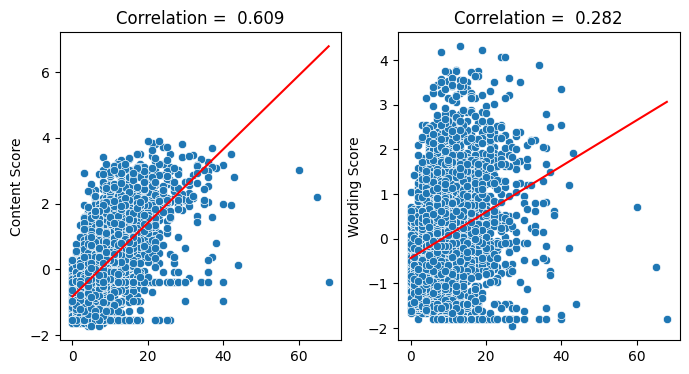

In [4]:
def count_common_words(prompt_id, keywords_dict, text):
    keywords = set(tools.tokenize_doc(text))
    common = keywords.intersection(keywords_dict[prompt_id])
    return len(common)

documents = prompts_df['prompt_text'].values
doc_keywords = tools.tf_idf(documents, 100)
keywords_dict = {}
for i in range(len(doc_keywords)):
    keywords_dict[prompts_df.iloc[i, 0]] = set(doc_keywords[i])

counts = []
for i in tqdm(range(summaries_df.shape[0])):
    prompt_id = summaries_df.iloc[i, 1]
    text = summaries_df.iloc[i, 2]
    counts.append(count_common_words(prompt_id, keywords_dict, text))
scores = np.array(counts)

tools.plot_correlations(scores, summaries_df, deg=1)


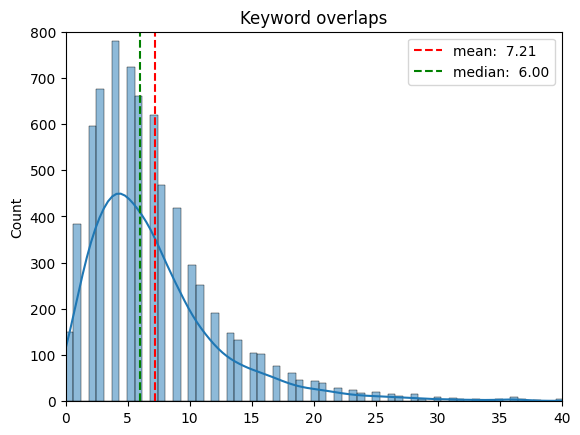

In [5]:
sns.histplot(x=scores, kde=True)
mean = np.mean(scores)
median = np.median(scores)
plt.vlines(x=mean, ymin=0, ymax=900, color='red', linestyles=['dashed'], label=f'mean: {mean: .2f}')
plt.vlines(x=median, ymin=0, ymax=900, color='green', linestyles=['dashed'], label=f'median: {median: .2f}')
plt.xlim(left=0, right=40)
plt.ylim(top=800)
plt.legend()
plt.title('Keyword overlaps')
plt.show()

In [6]:
summaries_df['keyword_overlap'] = scores

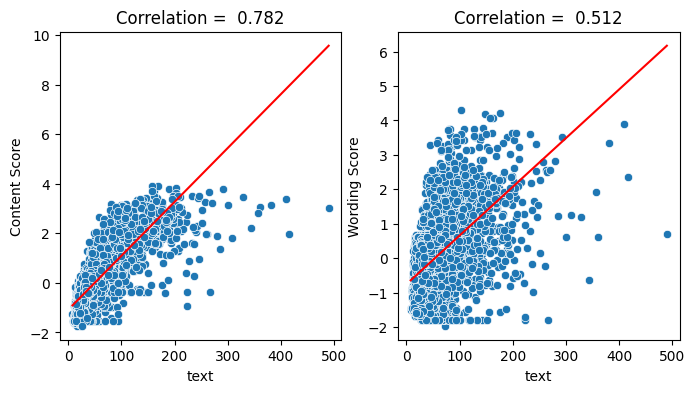

In [7]:
summary_lengths = summaries_df['text'].apply(tools.count_words)
tools.plot_correlations(summary_lengths, summaries_df, deg=1)

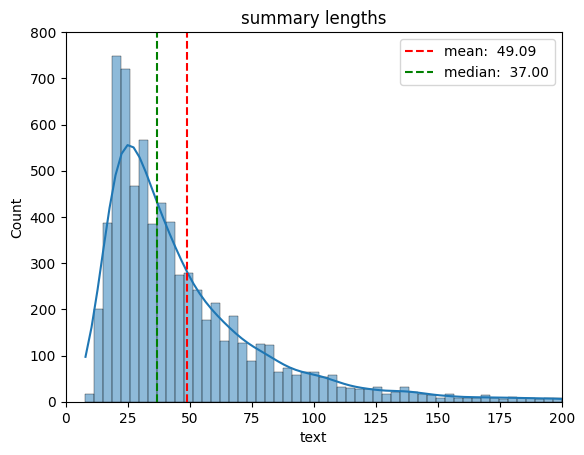

In [8]:
sns.histplot(x=summary_lengths, kde=True)
mean = np.mean(summary_lengths)
median = np.median(summary_lengths)
plt.vlines(x=mean, ymin=0, ymax=900, color='red', linestyles=['dashed'], label=f'mean: {mean: .2f}')
plt.vlines(x=median, ymin=0, ymax=900, color='green', linestyles=['dashed'], label=f'median: {median: .2f}')
plt.xlim(left=0, right=200)
plt.ylim(top=800)
plt.legend()
plt.title('summary lengths')
plt.show()

In [9]:
summaries_df['summary_lengths'] = summary_lengths

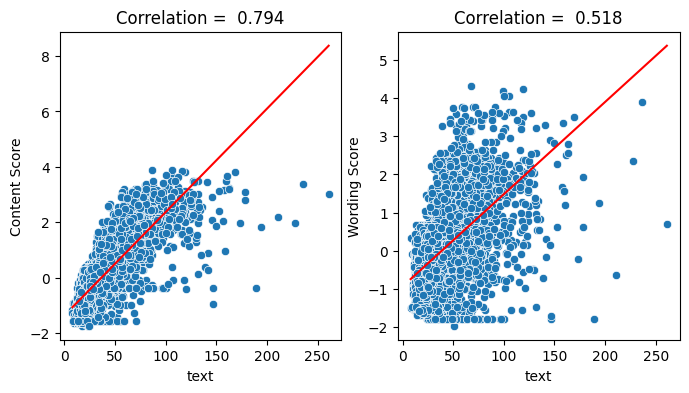

In [10]:
vocab_size = summaries_df['text'].apply(lambda x: tools.count_words(x, vocab=True))
tools.plot_correlations(vocab_size, summaries_df, deg=1)

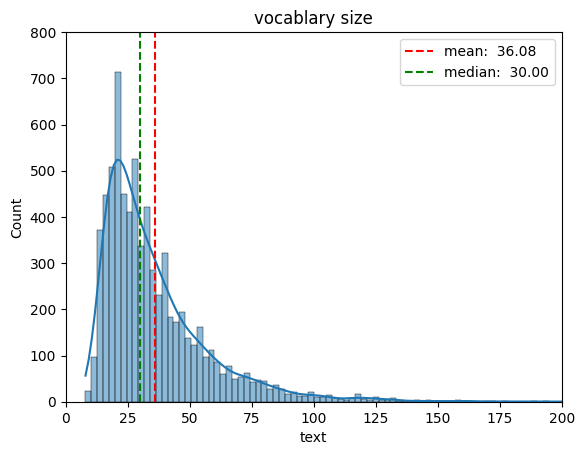

In [11]:
sns.histplot(x=vocab_size, kde=True)
mean = np.mean(vocab_size)
median = np.median(vocab_size)
plt.vlines(x=mean, ymin=0, ymax=900, color='red', linestyles=['dashed'], label=f'mean: {mean: .2f}')
plt.vlines(x=median, ymin=0, ymax=900, color='green', linestyles=['dashed'], label=f'median: {median: .2f}')
plt.xlim(left=0, right=200)
plt.ylim(top=800)
plt.legend()
plt.title('vocablary size')
plt.show()

In [12]:
summaries_df['vocab_size'] = vocab_size

### Average sentence length ratios

  0%|          | 0/7165 [00:00<?, ?it/s]

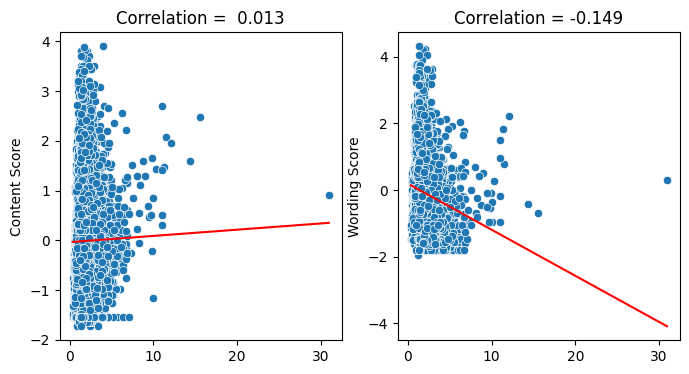

In [13]:
def compare_sentence_lengths(sentence_lengths_dict, prompt_id, text):
    sentence_summary_words = tools.count_sentences(text, word_count=True)
    ratio = sentence_summary_words / sentence_lengths_dict[prompt_id] 
    return ratio

sentence_lengths_dict = {}
for i in range(prompts_df.shape[0]):
    sentence_lengths_dict[prompts_df.iloc[i, 0]] = \
        tools.count_sentences(prompts_df.iloc[i, 1], word_count=True)
    
counts = []
for i in tqdm(range(summaries_df.shape[0])):
    prompt_id = summaries_df.iloc[i, 1]
    text = summaries_df.iloc[i, 2]
    counts.append(compare_sentence_lengths(sentence_lengths_dict, prompt_id, text))   
    
tools.plot_correlations(np.array(counts), summaries_df, deg=1)

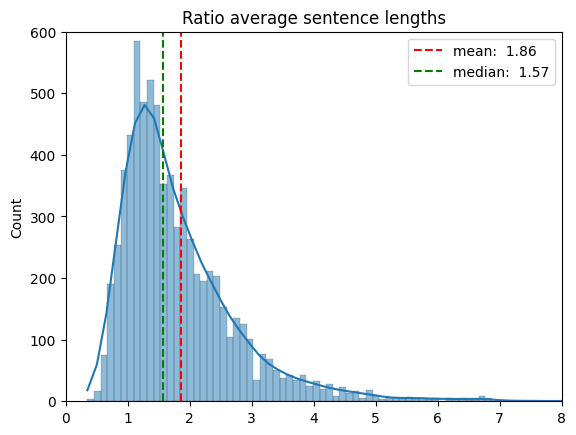

In [14]:
sns.histplot(x=counts, kde=True)
mean = np.mean(counts)
median = np.median(counts)
plt.vlines(x=mean, ymin=0, ymax=900, color='red', linestyles=['dashed'], label=f'mean: {mean: .2f}')
plt.vlines(x=median, ymin=0, ymax=900, color='green', linestyles=['dashed'], label=f'median: {median: .2f}')
plt.xlim(left=0, right=8)
plt.ylim(top=600)
plt.legend()
plt.title('Ratio average sentence lengths')
plt.show()

In [15]:
summaries_df['Average_sentence_lengths_ratio'] = counts

### Objectivity

In [16]:
objectivity_values = []
for i in tqdm(range(summaries_df.shape[0])):
    value = tools.objectivity(summaries_df.iloc[i, 2])
    objectivity_values.append(value)
objectivity_values = np.array(objectivity_values)

  0%|          | 0/7165 [00:00<?, ?it/s]

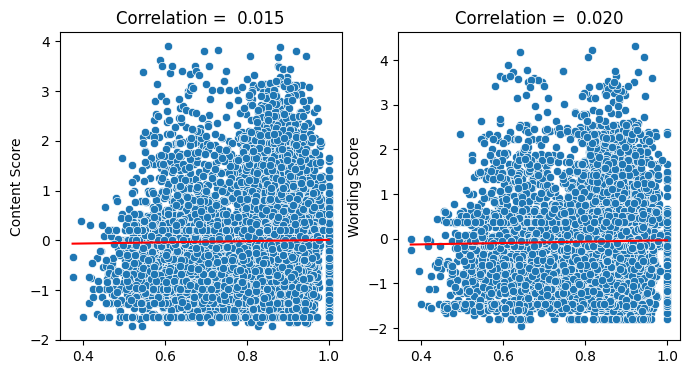

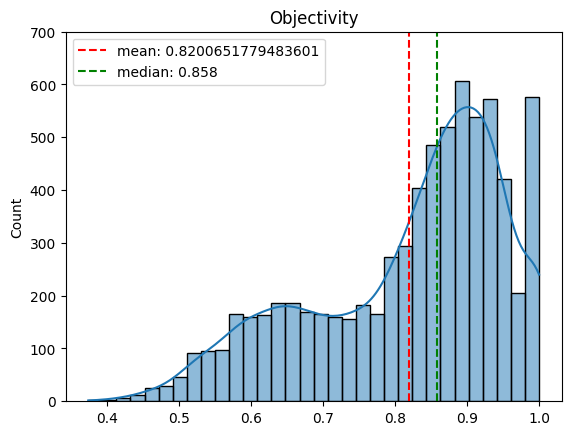

In [17]:
tools.plot_correlations(objectivity_values, summaries_df, deg=1)

mean = np.mean(objectivity_values)
median = np.median(objectivity_values)

sns.histplot(x=objectivity_values, kde=True)
plt.vlines(mean, ymin=0, ymax=800, color='red', linestyles='dashed', label=f'mean: {mean}')
plt.vlines(median, ymin=0, ymax=800, color='green', linestyles='dashed', label=f'median: {median}')
plt.title("Objectivity")
plt.legend()
plt.ylim(top=700)
plt.show()

In [18]:
summaries_df['objectivity'] = objectivity_values

### Semantic similarity 

  0%|          | 0/7165 [00:00<?, ?it/s]

  0%|          | 0/7165 [00:00<?, ?it/s]

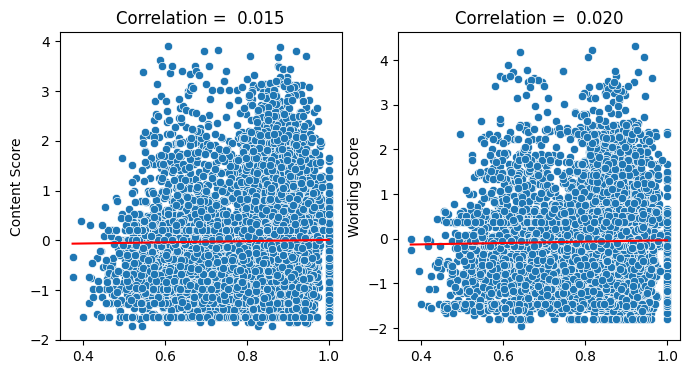

In [19]:
documents = summaries_df['text'].values
doc_keywords = tools.tf_idf(documents, 100)

scorer = SemanticScore()
scores = []
for i in tqdm(range(summaries_df.shape[0])):
    prompt_id = summaries_df.iloc[1, 1]
    score = scorer.similarity(keywords_dict[prompt_id], doc_keywords[i])
    scores.append(score)

tools.plot_correlations(objectivity_values, summaries_df, deg=1)


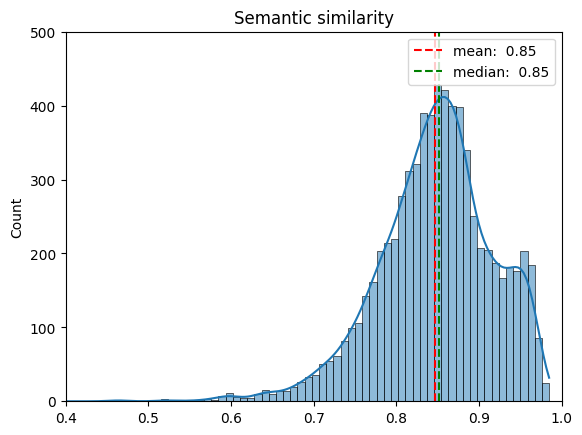

In [20]:
sns.histplot(x=scores, kde=True)
mean = np.mean(scores)
median = np.median(scores)
plt.vlines(x=mean, ymin=0, ymax=900, color='red', linestyles=['dashed'], label=f'mean: {mean: .2f}')
plt.vlines(x=median, ymin=0, ymax=900, color='green', linestyles=['dashed'], label=f'median: {median: .2f}')
plt.xlim(left=0.4, right=1)
plt.ylim(top=500)
plt.legend()
plt.title('Semantic similarity')
plt.show()

In [21]:
summaries_df['Semantic_similarity'] = scores

### Flesch-Kincaid reading ease score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/7165 [00:00<?, ?it/s]

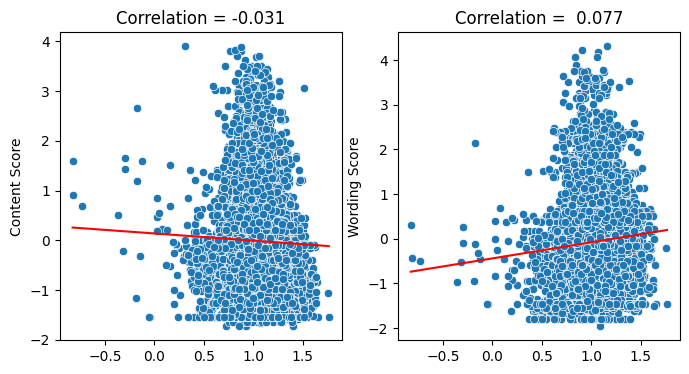

In [22]:
download('punkt')

prompt_readabilities = {}
for i in range(prompts_df.shape[0]):
    prompt_id = prompts_df.iloc[i, 0]
    text = prompts_df.iloc[i, 3]
    fk = textstat.flesch_reading_ease(text)
    prompt_readabilities[prompt_id] = fk

scores = []
for i in tqdm(range(summaries_df.shape[0])):
    prompt_id = summaries_df.iloc[i, 1]
    text = summaries_df.iloc[i, 2]
    fk = textstat.flesch_reading_ease(text)
    scores.append(fk / prompt_readabilities[prompt_id])
scores = np.array(scores)

tools.plot_correlations(scores, summaries_df, deg=1)

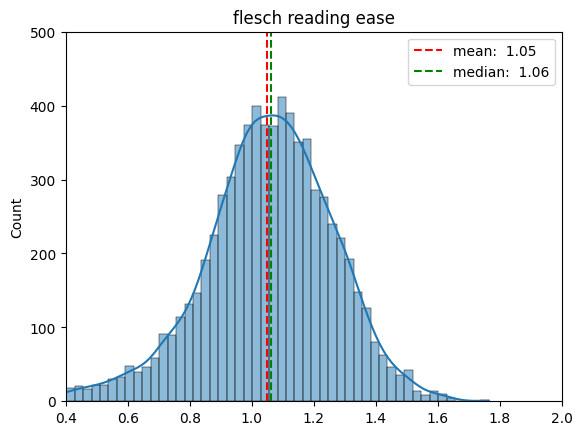

In [23]:
sns.histplot(x=scores, kde=True)
mean = np.mean(scores)
median = np.median(scores)
plt.vlines(x=mean, ymin=0, ymax=900, color='red', linestyles=['dashed'], label=f'mean: {mean: .2f}')
plt.vlines(x=median, ymin=0, ymax=900, color='green', linestyles=['dashed'], label=f'median: {median: .2f}')
plt.xlim(left=0.4, right=2)
plt.ylim(top=500)
plt.legend()
plt.title('flesch reading ease')
plt.show()

In [24]:
summaries_df['flesch_reading_ease'] = scores

### Count spelling errors

  0%|          | 0/7165 [00:00<?, ?it/s]

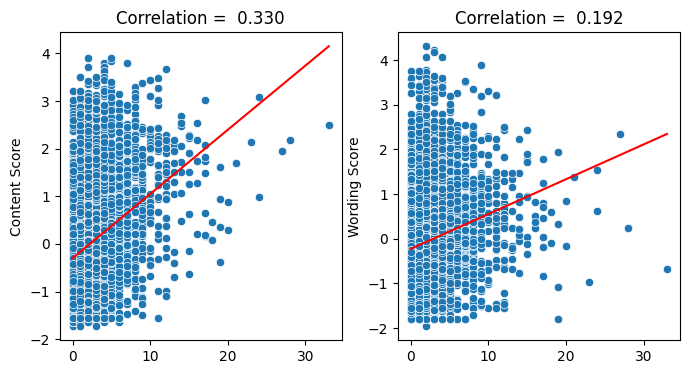

In [25]:
spell_checker = SpellChecker()
error_counts = []
for i in tqdm(range(summaries_df.shape[0])):
    text = summaries_df.iloc[i, 2].lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    errors = spell_checker.unknown(tokens)
    error_counts.append(len(errors))
error_counts = np.array(error_counts)

tools.plot_correlations(error_counts, summaries_df, deg=1)

In [26]:
summaries_df['spell_errors'] = error_counts

In [27]:
summaries_df.head()

,student_id,prompt_id,text,content,wording,keyword_overlap,summary_lengths,vocab_size,Average_sentence_lengths_ratio,objectivity,Semantic_similarity,flesch_reading_ease,spell_errors
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,4,43,36,1.075000,0.835,0.854158,1.136179,2
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,5,25,19,1.785714,0.947,0.889245,1.319293,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,19,177,119,2.011364,0.816,0.877361,0.906089,3
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,3,18,16,1.227273,1.000,0.706003,0.944525,4
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,12,151,101,1.078571,0.898,0.866760,1.150467,11


In [28]:
summaries_df.iloc[:, 3:].to_csv(os.path.join('data', 'features.csv'), index=False)